## Data analysis code for gain=5000 data taken on 07/14/2025.

In [1]:
import numpy as np  
import matplotlib.pyplot as plt
import re
import os
from scipy import optimize
from scipy.ndimage import gaussian_filter
import h5py
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from scipy.signal import butter, sosfiltfilt, sosfreqz

In [2]:
def line_func(x, A, B):
    return A*x + B
def smooth(data,window=5,poly_order=3):
    '''Function for smoothing data. Currently uses Savitzky-Golay filter,
    which fits a window of data onto a polynomial of some order, and then
    uses the polynomial to estimate the value'''
    #window value must be odd
    if window % 2 == 0:
        window+=1
    smoothed_data = savgol_filter(data, window, poly_order)
    return smoothed_data

def butter_lowpass_filter(data, lowcut, fs, order=5):
    sos = butter_lowpass(lowcut, fs, order=order)
    y = sosfiltfilt(sos, data)
    return y

def butter_lowpass(lowcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    sos = butter(order, low, analog=False, btype='lowpass', output='sos')
    return sos

# Binning 1x1

In [3]:
folder_path_day = r'C:\Experiments\lyman29\BaF_Fluorescence\2025\07\18'

C:\Users\PolyEDM\AppData\Local\Temp\ipykernel_26588\1933217948.py:162: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 1])


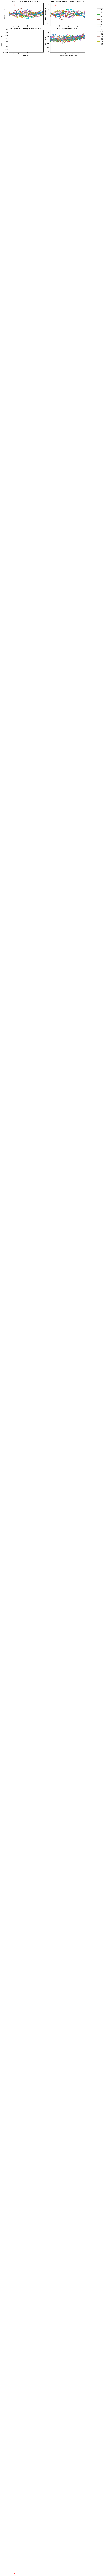

In [8]:
seq =18 #sequence number
folder_path = folder_path_day + r'/%.4i'%seq

plt.close()

# smooth_method = 'no filter'
# smooth_method = 'lowpass'
smooth_method = 'savgol'
# smooth_method = 'both'

count_b_start=0
count_b_end=20

abs_sums=[]
fluor_sums = []
tYAG=2

# LIF
conversion = 0.016*8/5 #EMCCD pixel size=0.016mm and optical magnification=8/5 on FOV

# Setup subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Unpack individual axes
ax_abs1 = axes[0, 0]
ax_abs2 = axes[0, 1]
ax_abs3 = axes[1, 0]
ax_lif  = axes[1, 1]
abs_traces = ['Absorption', 'Absorption2', 'Absorption3']
abs_axes = [ax_abs1, ax_abs2, ax_abs3] 
abs_labels = ['Absorption (I)', 'Absorption (Q)', 'Absorption (DC)']

last_file = ''
for count_b, filename in enumerate(os.listdir(folder_path)): 
    file_path = os.path.join(folder_path, filename)
    # print(filename)
    if count_b<=count_b_end and count_b>=count_b_start: #POINT WE STOPPED TAKING DATA...
        if os.path.exists(file_path):
            last_file = count_b
            pass
        else:
            continue
        with h5py.File(file_path, 'r') as file:
            ## Absorption ############
            for i, (trace_name, ax_abs) in enumerate(zip(abs_traces, abs_axes)):
                analog_data = file[f'data/traces/{trace_name}'][:]
                times, values = zip(*analog_data)
                # Convert to NumPy arrays if needed
                time_ms = np.array(times)*1000
                values = np.array(values)
    
                #collect useful indices. Could have also done times.searchsorted()
                trigger_index = np.searchsorted(time_ms,tYAG)
                beforeYAG_index = np.searchsorted(time_ms,1.95) # hardcoded values are on the absorption data timeframe.
                after_abs_index = np.searchsorted(time_ms,10)
                end_index = np.searchsorted(time_ms,15)
            
                #Remove linear drift and find offset 
                fit_time = np.concatenate((time_ms[:beforeYAG_index],time_ms[after_abs_index:end_index]))
                fit_data = np.concatenate((values[:beforeYAG_index],values[after_abs_index:end_index]))
                popt, _ = curve_fit(line_func, fit_time, fit_data, p0=[(fit_data[-1]-fit_data[0])/(time_ms[-1]-time_ms[0]),fit_data.mean()])
                slope=popt[0]
                intercept=popt[1]
                flat_data =  values - line_func(time_ms,slope,intercept)
                offset = flat_data[:trigger_index].mean()
    
                #Plot on absorption subplot
                ax_abs.plot(time_ms-tYAG, flat_data, label=f'#{count_b}')
        
                #Sum of absorption signals
                dt=(time_ms[1]-time_ms[0])
                abs_sum = np.sum(abs(flat_data[time_ms.searchsorted(tYAG+0.05):time_ms.searchsorted(tYAG+6)]))*dt
                # -------- PLOT FORMATTING --------
                ax_abs.set_title(f'{abs_labels[i]} in Seq.{seq} from #{count_b_start} to #{last_file}', fontsize=14)
                ax_abs.set_xlabel('Time [ms]', fontsize=14)
                ax_abs.set_ylabel(abs_labels[i], fontsize=14)
                # ax_abs.legend(fontsize=8)
                # ----------------------------------
            ####################################


            
            ## LIF ########################
            image_data = file['images/camera/fluorescence/frame'][:]
            cross_section_x = np.mean(image_data, axis=0)
            x = np.arange(512)

            filter_freq = 0.05
            if smooth_method == 'lowpass': #Smoothing with lowpass filter
                N = len(x)
                delta_s = (x[1]-x[0])
                fs = np.round(1/delta_s,4)
                lowcut = filter_freq
                order=2
                filtered_data = butter_lowpass_filter(cross_section_x,lowcut,fs,order=order)
            elif smooth_method == 'savgol': #Smoothing with polynomial filter
                filtered_data = smooth(cross_section_x,window=20,poly_order=3)
            elif smooth_method == 'both': #Smoothing with both filters
                N = len(x)
                delta_s = (x[1]-x[0])
                fs = np.round(1/delta_s,4)
                lowcut = filter_freq
                order=2
                filt1 = butter_lowpass_filter(cross_section_x,lowcut,fs,order=order)
                filt2 = smooth(cross_section_x,window=25,poly_order=3)
                filtered_data = np.array([filt1,filt2]).T
            else: # No filter
                filtered_data = cross_section_x
                
            #Plot on LIF subplot
            pixel_mm = x * conversion
            ax_lif.plot(pixel_mm, filtered_data, label=f'#{count_b}')
            
            # plt.figure(2)
            # plt.plot(pixel_mm,filtered_data, label=count_b)

            #Sum of LIF signals
            ADC_base = filtered_data[0:50].mean()
            fluor_sum = np.sum((filtered_data[x.searchsorted(3.5/conversion):x.searchsorted(8.5/conversion)]-ADC_base))
            abs_sums.append(abs_sum)
            fluor_sums.append(fluor_sum)
            ####################################




# -------- PLOT FORMATTING --------
# Absorption Plot
for ax_abs in abs_axes:
    ax_abs.axvline(x=0, color='r', linestyle='--')
    ax_abs.text(0.4, ax_abs.get_ylim()[1] * 0.85 + ax_abs.get_ylim()[0] * 0.15, 'YAG', color='r', fontsize=12, rotation=90, verticalalignment='bottom', horizontalalignment='center')
    x_range = (0 - tYAG, 15 - tYAG)
    ax_abs.set_xlim(x_range[0], x_range[1])
    if ax_abs == ax_abs3:
        ax_abs.set_ylim([-1, 1])
        for txt in ax_abs.texts:
            txt.remove()
        ax_abs.text(0.4, -1.5 * 0.15 + ax_abs.get_ylim()[1] * 0.85, 'YAG', color='r', fontsize=12, rotation=90, verticalalignment='bottom', horizontalalignment='center')

## legend, comment ouf if you don't need ###
# --- Collect legend handles and labels from all axes ---
handles = []
labels = []
for ax in abs_axes:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)
# Remove duplicates
legend_dict = dict(zip(labels, handles))
unique_labels = list(legend_dict.keys())
unique_handles = list(legend_dict.values())
# --- Add global legend to the figure ---
fig.legend(unique_handles, unique_labels, loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=10, title='Shot #')
####################################

# LIF Plot
ax_lif.set_title(f'LIF in Seq.{seq} from #{count_b_start} to #{last_file}', fontsize=14)
ax_lif.set_xlabel('Distance Along Beam (mm)', fontsize=12)
ax_lif.set_ylabel('ADC Counts', fontsize=12)
ax_lif.set_xlim(0 + 50 * conversion, (512 - 50) * conversion)

plt.tight_layout(rect=[0, 0, 1, 1])

# ----------------------------------


# # -------- ABS vs LIF CORRELATION --------
# plt.figure(3)
# abs_sums = np.array(abs_sums).T
# plt.plot(abs_sums,fluor_sums,'ko',label='all abs')
# plt.xscale('log')
# plt.yscale('log')
# plt.xlabel('FM Cell Signal, Ba', fontsize=14)
# plt.ylabel('LIF Beam Signal, BaF', fontsize=14)
# plt.title('Correlation between Abs and LIF signals', fontsize=14)

plt.show()

2025-07-18_0005_BaF_Fluorescence_00.h5


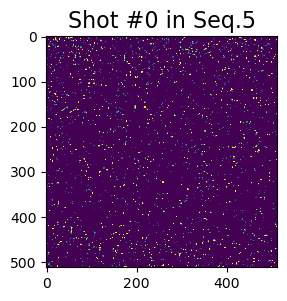

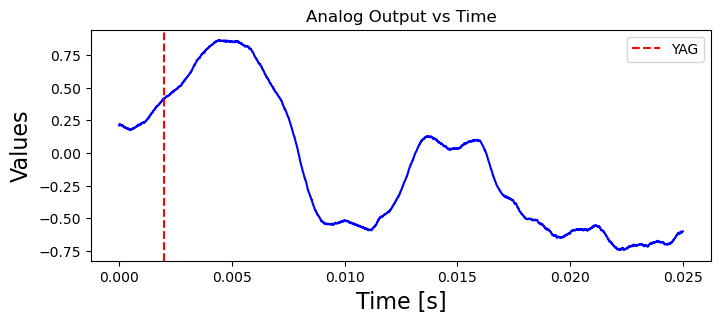

2025-07-18_0005_BaF_Fluorescence_01.h5


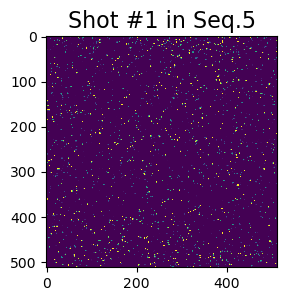

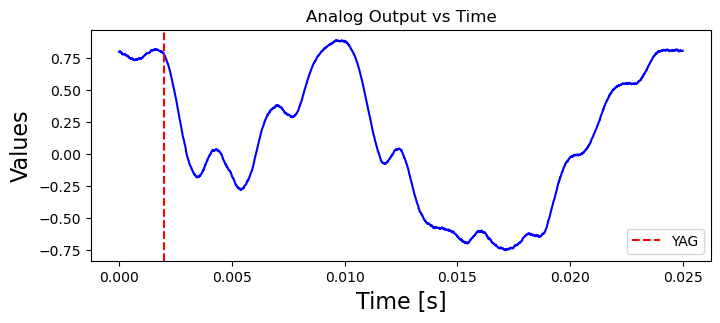

In [104]:
##Show Absorption and FLuorescence plots of a shot
for n in range(2):
    
    shot_number =n #Choose shot number you want to see
    
    folder_path = folder_path_day + r'/%.4i'%seq
    for count_b, filename in enumerate(os.listdir(folder_path)):
          if count_b==shot_number: 
              file_path = os.path.join(folder_path, filename)
              print(filename)
              with h5py.File(file_path, 'r') as file:
                image_data = file['images/camera/fluorescence/frame'][:]
                analog_data=file['data/traces/Absorption'][:]
                # print(analog_data)
                times, values = zip(*analog_data)
                # Convert to NumPy arrays if needed
                times = np.array(times)
                values = np.array(values)
                tYAG=2e-3 # Hardcoded for now...
                fig = plt.figure(2, figsize=(3, 3))
                plt.imshow(image_data, vmin = 1550, vmax = 1600)
                plt.title('Shot #%i in Seq.%i' % (shot_number, seq), fontsize=16)
                
                fig = plt.figure(4, figsize=(8, 3))
                plt.plot(times, values, 'b')
                plt.axvline(x=tYAG, color='r', linestyle='--', label='YAG')
                plt.xlabel('Time [s]', fontsize=16)
                plt.ylabel('Values', fontsize=16)
                plt.title('Analog Output vs Time')
                plt.legend()  # Add this if you want the 'YAG' label to show
                plt.show()

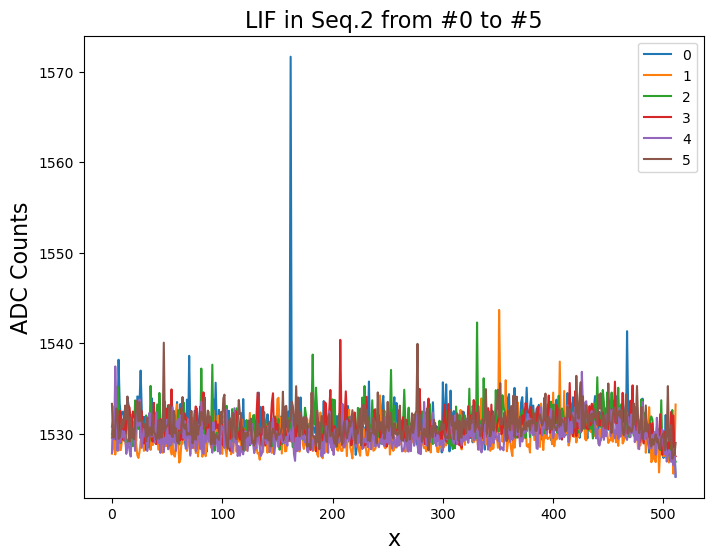

In [17]:
count_b_start=0
count_b_end=5
sum_array=[]
fig = plt.figure(20, figsize=(8,6))
# get x-cross section for every shot in the sequence
for count_b, filename in enumerate(os.listdir(folder_path)): 
    file_path = os.path.join(folder_path, filename)
    # print(filename)
    if count_b<=count_b_end and count_b>=count_b_start:
        with h5py.File(file_path, 'r') as file:
            image_data = file['images/camera/fluorescence/frame'][:]
            cross_section_x = np.mean(image_data, axis=0)
            # if np.any(cross_section_x>1550):
            plt.plot(np.arange(512),cross_section_x, label=count_b)
            # print(count_b)
            # print(np.sum(cross_section_x))
            sum_array.append(np.sum(cross_section_x))
            # else:
                # plt.plot(np.arange(512),cross_section_x, label='')


# plt.ylim([1528,1660])
plt.xlabel('x', fontsize=16)
# plt.title('Shots in Seq.7', fontsize=16)
plt.title('LIF in Seq.%i from #%i to #%i' %(seq, count_b_start, count_b_end), fontsize=16)
plt.ylabel('ADC Counts', fontsize=16)
plt.legend()
plt.show()



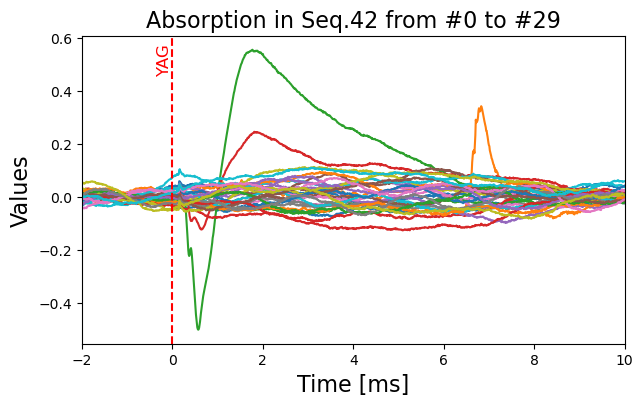

In [20]:
seq = 42
folder_path = folder_path_day + r'/%.4i'%seq

# ABSORPTION
plt.close()
count_b_start=0
count_b_end=100
sum_array=[]

fig = plt.figure(20, figsize=(7,4))
# get x-cross section for every shot in the sequence
last_file = ''
for count_b, filename in enumerate(os.listdir(folder_path)): 
    file_path = os.path.join(folder_path, filename)
    # print(filename)
    if count_b<=count_b_end and count_b>=count_b_start: #POINT WE STOPPED TAKING DATA...
        if os.path.exists(file_path):
            last_file = count_b
            pass
        else:
            continue
        # if count_b%10==2:
        # print(count_b)
        with h5py.File(file_path, 'r') as file:
            analog_data=file['data/traces/Absorption'][:]
            # print(analog_data)
            times, values = zip(*analog_data)
            # Convert to NumPy arrays if needed
            times = np.array(times)*1000 
            time_ms = times - 2
            values = np.array(values)

            #collect useful indices. Could have also done times.searchsorted()
            trigger_index = np.searchsorted(time_ms,2-2)
            beforeYAG_index = np.searchsorted(time_ms,1.95-2)
            after_abs_index = np.searchsorted(time_ms,10-2)
            end_index = np.searchsorted(time_ms,15-2)
        
            #Remove linear drift and find offset
            fit_time = np.concatenate((time_ms[:beforeYAG_index],time_ms[after_abs_index:end_index]))
            fit_data = np.concatenate((values[:beforeYAG_index],values[after_abs_index:end_index]))
            popt, _ = curve_fit(line_func, fit_time , fit_data,p0=[(fit_data[-1]-fit_data[0])/(time_ms[-1]-time_ms[0]),fit_data.mean()])
            slope=popt[0]
            intercept=popt[1]
            flat_data =  values - line_func(time_ms,slope,intercept)
            offset = flat_data[:trigger_index].mean()

            
            
    
            
            plt.plot(time_ms, flat_data, label=count_b)


tYAG=0 # [ms], Hardcoded for now...
plt.text(tYAG, plt.ylim()[1]*0.95, 'YAG', color='r', fontsize=12, rotation=90,
         verticalalignment='top', horizontalalignment='right')
plt.axvline(x=tYAG, color='r', linestyle='--')
plt.xlabel('Time [ms]', fontsize=16)
plt.ylabel('Values', fontsize=16)
plt.xlim([0-2,12-2])
plt.title('Absorption in Seq.%i from #%i to #%i' %(seq, int(count_b_start), int(count_b)), fontsize=16)
# plt.legend()  # Add this if you want the 'YAG' label to show
plt.show()

